In [1]:
import pandas as pd
import numpy as np
import itertools as it

import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.ticker as mtick

pd.set_option('display.max_columns',50)

plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

%matplotlib inline

In [2]:
def get_ci(df, col, gb_col='date', percentile='95'):
    if percentile == '999':
        cival = 3.291
    if percentile == '995':
        cival = 2.807
    if percentile == '99':
        cival = 2.576
    if percentile == '95':
        cival = 1.96
    if percentile == '90':
        cival = 1.645
    if percentile == '80':
        cival = 1.282

    df_stats = df.groupby(gb_col)[col].agg([np.nanmean,'count',np.nanstd])
    ci95_hi = []
    ci95_lo = []
    for i in df_stats.index:
        m, c, s = df_stats.loc[i]
        ci95_hi.append(m + cival*s/np.sqrt(c))
        ci95_lo.append(m - cival*s/np.sqrt(c))
    df_stats['ci95_hi'] = ci95_hi
    df_stats['ci95_lo'] = ci95_lo

    return df_stats.reset_index()

In [3]:
month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}

today = str(dt.datetime.date(dt.datetime.now()))

# make DATE_DF, a simple dataframe with dates, weekdays, and weeknums
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',
                   4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-01', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATE_DF = DATE_DF.loc[DATE_DF['date']<=today].copy()
DATERANGE = DATE_DF['date'].tolist()
date_dict = dict(zip(DATERANGE,list(range(len(DATERANGE)))))
dates_tt = [i for i in DATERANGE if i[-2:]=='01']
dates_ll = [month_dict[i[5:7]] if i[5:7]!='01' else i[:4] for i in dates_tt]

In [4]:
fs = 9
lw = 2
wid = 21
cols = ['steelblue','peru','darkslategrey','palevioletred']
cols2 = ["mediumseagreen","#2f4d5d"]

pe1 = [path_effects.Stroke(linewidth=1.5,foreground='w'),path_effects.Normal()]
pe2 = [path_effects.Stroke(linewidth=lw*1.5,foreground='w',alpha=0.9),path_effects.Normal()]

plot_min_date = '2020-07-13'
plot_max_date = '2021-01-08'

In [5]:
ihe_df    = pd.read_csv('../data/campus_covid_fall2020_full.csv', dtype={'ipeds_id':str, 'fips':str})
ipeds_df  = pd.read_csv('../data/campus_covid_ipeds.csv',         dtype={'ipeds_id':str, 'fips':str})
status_df = pd.read_csv('../data/campus_covid_status.csv',        dtype={'ipeds_id':str, 'fips':str})
census_df = pd.read_csv('../data/campus_covid_census.csv',        dtype={'fips':str})
jhu_df    = pd.read_csv('../data/campus_covid_jhu_county.csv.gz', dtype={'fips':str})

In [6]:
summary_df = status_df.groupby(['fips','status_merge']
                               ).agg({'ihe_fulltime_population':'sum'}).reset_index()
summary_df = summary_df.merge(jhu_df[['fips','county_population']].drop_duplicates(),
                              how='left', on='fips')
summary_df['enrollment_fulltime'] = summary_df['ihe_fulltime_population']
summary_df['total_pop'] = summary_df['county_population']
summary_df['frac_pop_enrollment_fulltime'] = summary_df['enrollment_fulltime']/summary_df['total_pop']
summary_df.head()

,fips,status_merge,ihe_fulltime_population,county_population,enrollment_fulltime,total_pop,frac_pop_enrollment_fulltime
0,01003,Primarily Online,3854,223234,3854,223234,0.017264
1,01015,Primarily Online,6738,113605,6738,113605,0.059311
2,01031,Primarily Online,1039,52342,1039,52342,0.019850
3,01033,Hybrid,1654,55241,1654,55241,0.029942
4,01035,Primarily Online,209,12067,209,12067,0.017320


In [7]:
percent_thresh = 0.036701726024525115

fips_inperson = summary_df.loc[(summary_df['frac_pop_enrollment_fulltime']>percent_thresh)&\
                               (summary_df['status_merge']=='Primarily In Person')]['fips'].unique()
print(len(fips_inperson))

fips_online = summary_df.loc[(summary_df['frac_pop_enrollment_fulltime']>percent_thresh)&\
                             (summary_df['status_merge']=='Primarily Online')]['fips'].values
fips_online = [i for i in fips_online if i not in fips_inperson]
print(len(fips_online))

college_county_fips = list(fips_online) + list(fips_inperson)

234
221


In [8]:
ll_online = jhu_df.loc[jhu_df['fips'].isin(fips_online)].copy()
ll_person = jhu_df.loc[jhu_df['fips'].isin(fips_inperson)].copy()

plot_dfs = [ll_online, ll_person]
labs = ['"college counties" w/ primarily\nonline enrollment (n=%i)'%(len(fips_online)),
        '"college counties" w/ primarily\nin person enrollment (n=%i)'%(len(fips_inperson))]

var1 = 'new_cases_per100k'
var2 = 'new_deaths_per100k'
plot_vars = [var1, var2]

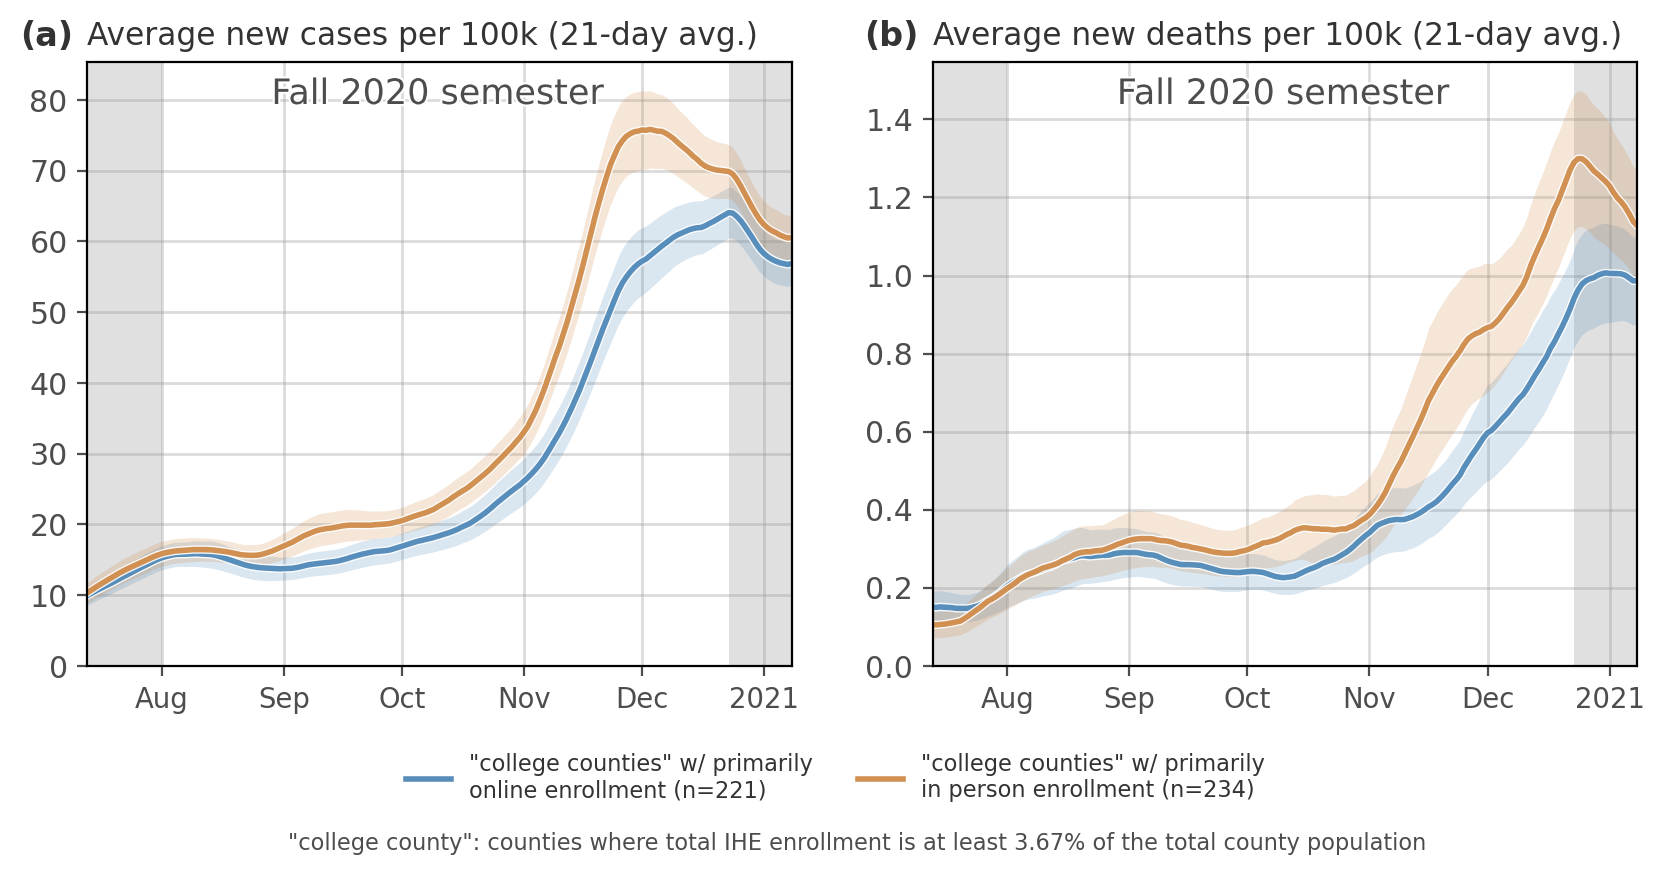

In [9]:
fig, ax = plt.subplots(1,2,figsize=(10,4),dpi=200)
plt.subplots_adjust(wspace=0.2)

for ix,var_i in enumerate(plot_vars):
    for li, llg in enumerate(plot_dfs):
        llg_i = get_ci(llg, var_i, gb_col='date', percentile='90')
        ax[ix].plot([date_dict[i] for i in llg_i['date'].values],
                    llg_i['nanmean'].rolling(window=wid).mean().values,
                    label=labs[li], lw=lw, alpha=0.9, color=cols[li],
                    path_effects=pe2)
        ax[ix].fill_between([date_dict[i] for i in llg_i['date'].values],
                            llg_i['ci95_lo'].rolling(window=wid).mean().values,
                            llg_i['ci95_hi'].rolling(window=wid).mean().values,
                            alpha=0.2, lw=0, color=cols[li])

    ylim0 = ax[ix].get_ylim()
    ax[ix].fill_between([date_dict[plot_min_date],date_dict['2020-08-01']],0,ylim0[1],
                       color='.7', alpha=0.4, zorder=0, lw=0)
    ax[ix].fill_between([date_dict['2020-12-23'],date_dict[plot_max_date]],0,ylim0[1],
                       color='.7', alpha=0.4, zorder=0, lw=0)
    ax[ix].text(date_dict['2020-10-10'],ylim0[1]*0.975,'Fall 2020 semester',
                va='top',ha='center',color='.3', path_effects=pe1, fontsize=fs*1.4)
    ax[ix].set_ylim(0,ylim0[1])


ax[0].set_title('Average new cases per 100k (%i-day avg.)'%wid, color='.2',
                x=0,ha='left',fontsize=fs*1.25)
ax[1].set_title('Average new deaths per 100k (%i-day avg.)'%wid, color='.2',
                x=0,ha='left',fontsize=fs*1.25)

l = ax[0].legend(fontsize=fs*0.9, loc=1, ncol=3, framealpha=0, bbox_to_anchor=[1.7, -0.11])
for text in l.get_texts():
    text.set_color('.2')


letts = ["(a)","(b)"]
for ai, a in enumerate(fig.axes):
    a.text(-0.02, 1.015, letts[ai], ha='right', va='bottom', transform=a.transAxes,
           fontweight='bold', fontsize='large', color='.2')
    a.set_xticks([date_dict[i] for i in dates_tt])
    a.set_xticklabels(dates_ll)
    a.tick_params(axis='y', labelcolor='.3', color='.3',labelsize=fs*1.2)
    a.tick_params(axis='x', labelcolor='.3', color='.3',labelsize=fs*1.1)
    a.grid(linewidth=1.0, color='.6', alpha=0.35)
    a.set_xlim(date_dict[plot_min_date], date_dict[plot_max_date])

ax[0].text(0.285, -0.275, '"college county": counties where total IHE enrollment '+\
                        'is at least %.2f%% of the total county population'%(percent_thresh*100),
            ha='left',va='top',color='.3',fontsize=fs*0.9,transform=ax[0].transAxes)

plt.savefig('../figs/pngs/matching_casedeaths_x1.png', bbox_inches='tight', dpi=425)
plt.savefig('../figs/pdfs/matching_casedeaths_x1.pdf', bbox_inches='tight', dpi=425)
plt.show()

_________

In [10]:
ihe_dfg = ihe_df.groupby(['ipeds_id','fips']).agg({'cumulative_cases':'sum',
                                                   'cumulative_tests':'sum'}).reset_index()
cou_dfg = ihe_dfg.groupby(['fips']).agg({'cumulative_cases':'sum',
                                         'cumulative_tests':'sum'}).reset_index()
cou_dfg = cou_dfg.loc[cou_dfg['fips'].isin(college_county_fips)].copy()

testmin = 0
cou_dfg['testing'] = 'non testing'
cou_dfg.loc[cou_dfg['cumulative_tests']>testmin,'testing'] = 'testing'

In [11]:
non_online_df = summary_df.loc[~summary_df['status_merge'].isin(['Hybrid',
                                                 'Primarily Online'])].copy()
non_online_df = non_online_df.loc[non_online_df['frac_pop_enrollment_fulltime']>percent_thresh].copy()
county_fips_for_testing = non_online_df['fips'].unique()

In [12]:
cou_dfg_testing = cou_dfg.loc[cou_dfg['fips'].isin(county_fips_for_testing)].copy()

In [13]:
fips_testing = cou_dfg_testing.loc[cou_dfg_testing['testing']=='testing']['fips'].unique()
fips_nontest = cou_dfg_testing.loc[cou_dfg_testing['testing']!='testing']['fips'].unique()

ll_testing = jhu_df.loc[jhu_df['fips'].isin(fips_testing)].copy()
ll_nontest = jhu_df.loc[jhu_df['fips'].isin(fips_nontest)].copy()

plot_dfs = [ll_testing, ll_nontest]
labs = ['"college counties" that do\nreport campus testing (n=%i)'%(len(fips_testing)),
        '"college counties" that do not\nreport campus testing (n=%i)'%(len(fips_nontest))]

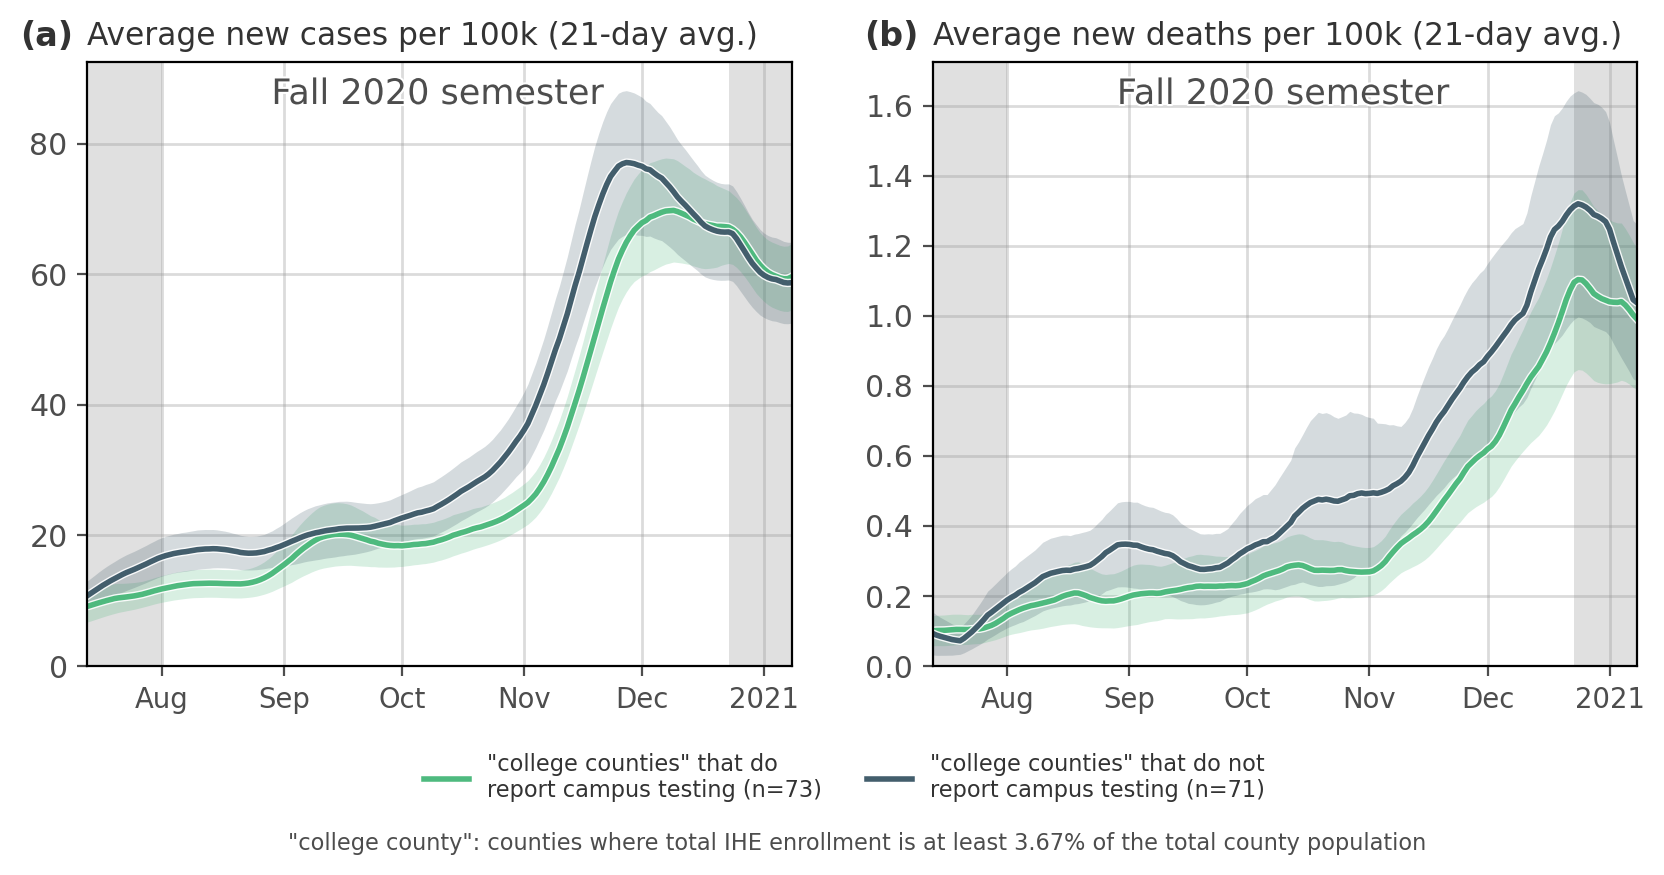

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,4),dpi=200)

plt.subplots_adjust(wspace=0.2)
for ix,var_i in enumerate(plot_vars):
    for li, llg in enumerate(plot_dfs):
        llg_i = get_ci(llg, var_i, gb_col='date', percentile='90')
        ax[ix].plot([date_dict[i] for i in llg_i['date'].values],
                    llg_i['nanmean'].rolling(window=wid).mean().values,
                    label=labs[li], lw=lw, alpha=0.9, color=cols2[li],
                    path_effects=pe2)
        ax[ix].fill_between([date_dict[i] for i in llg_i['date'].values],
                            llg_i['ci95_lo'].rolling(window=wid).mean().values,
                            llg_i['ci95_hi'].rolling(window=wid).mean().values,
                            alpha=0.2, lw=0, color=cols2[li])

    ylim0 = ax[ix].get_ylim()
    ax[ix].fill_between([date_dict[plot_min_date],date_dict['2020-08-01']],0,ylim0[1],
                       color='.7', alpha=0.4, zorder=0, lw=0)
    ax[ix].fill_between([date_dict['2020-12-23'],date_dict[plot_max_date]],0,ylim0[1],
                       color='.7', alpha=0.4, zorder=0, lw=0)
    ax[ix].text(date_dict['2020-10-10'],ylim0[1]*0.975,'Fall 2020 semester',
                va='top',ha='center',color='.3', path_effects=pe1, fontsize=fs*1.4)
    ax[ix].set_ylim(0,ylim0[1])

ax[0].set_title('Average new cases per 100k (%i-day avg.)'%wid, color='.2',
                x=0,ha='left',fontsize=fs*1.25)
ax[1].set_title('Average new deaths per 100k (%i-day avg.)'%wid, color='.2',
                x=0,ha='left',fontsize=fs*1.25)

l = ax[0].legend(fontsize=fs*0.9, loc=1, ncol=3, framealpha=0, bbox_to_anchor=[1.7, -0.11])
for text in l.get_texts():
    text.set_color('.2')

letts = ["(a)","(b)"]
for ai, a in enumerate(fig.axes):
    a.text(-0.02, 1.015, letts[ai], ha='right', va='bottom', transform=a.transAxes,
           fontweight='bold', fontsize='large', color='.2')
    a.set_xticks([date_dict[i] for i in dates_tt])
    a.set_xticklabels(dates_ll)
    a.tick_params(axis='y', labelcolor='.3', color='.3',labelsize=fs*1.2)
    a.tick_params(axis='x', labelcolor='.3', color='.3',labelsize=fs*1.1)
    a.grid(linewidth=1.0, color='.6', alpha=0.35)
    a.set_xlim(date_dict['2020-07-13'], date_dict['2021-01-08'])

ax[0].text(0.285, -0.275, '"college county": counties where total IHE enrollment '+\
                        'is at least %.2f%% of the total county population'%(percent_thresh*100),
            ha='left',va='top',color='.3',fontsize=fs*0.9,transform=ax[0].transAxes)

plt.savefig('../figs/pngs/matching_casedeaths_testing.png', bbox_inches='tight', dpi=425)
plt.savefig('../figs/pdfs/matching_casedeaths_testing.pdf', bbox_inches='tight', dpi=425)
plt.show()